<a href="https://colab.research.google.com/github/WonJunPark/Kaggle_DFDC/blob/master/dfdc_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 셋팅

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
work_root_path = "/content/gdrive/My Drive/Kaggle/DFDC2/"

# 라이브러리 import

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [0]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.4.0
CUDA version: 10.1
cuDNN version: 7603


# 이미지 업로드

In [0]:
df_train = []

# total = 50
df_train_num = 7   # 0~46
df_val_num = 1      # 47~49

df_trains = []
df_vals = []

for i in range(df_train_num):
  s = work_root_path + 'input/deepfake/metadata'+  str(i) +'.json'
  deepfake = pd.read_json(s)
  df_trains.append(deepfake)

for i in range(df_val_num):
  s = work_root_path + 'input/deepfake/metadata'+ str(df_train_num + i) +'.json'
  deepfake = pd.read_json(s)
  df_vals.append(deepfake)

nums = list(range(len(df_trains)+1))
LABELS = ['REAL','FAKE']
val_nums=[7]

In [0]:
df_trains[0]

,owxbbpjpch.mp4,vpmyeepbep.mp4,fzvpbrzssi.mp4,htorvhbcae.mp4,fckxaqjbxk.mp4,sphirandia.mp4,vsmadeuczx.mp4,ohaqlzfnuv.mp4,komngcqveq.mp4,iafvzgpbix.mp4,uaukglhmje.mp4,syxobtuucp.mp4,dtjcyzgdts.mp4,viuioldtnu.mp4,wnaweyzlqh.mp4,ejhhdlzpjg.mp4,sxyrkshzsg.mp4,uvfkppqsjy.mp4,kedahvzait.mp4,idczhqbbqz.mp4,clzkcmoyhb.mp4,vpjfmetsvn.mp4,muksyyltmg.mp4,ztwlbdwyni.mp4,jaurxwocly.mp4,jkxjvuioek.mp4,dhjnjkzuhq.mp4,xcruhaccxc.mp4,rfpjsloxzg.mp4,kmcdjxmnoa.mp4,vvwuqslvnq.mp4,rpxnyljmsf.mp4,txxungvxms.mp4,vtunvalyji.mp4,ihnhxathkq.mp4,lobxktzhbg.mp4,slhinthqcq.mp4,hqzwudvhih.mp4,xpzfhhwkwb.mp4,sglzgdcjkb.mp4,...,xvzjzkrmlm.mp4,ueobjeflda.mp4,runmncglnj.mp4,rqsjnyjukt.mp4,avznxuwvbx.mp4,zxprilbsxp.mp4,hwtupajxgl.mp4,pvlbqbyxxi.mp4,fpcncmwzxf.mp4,mnnxgycfik.mp4,ygfoblbxcx.mp4,jmkqtjuuqu.mp4,gczieafvpe.mp4,yljecirelf.mp4,dsgswagtvp.mp4,xjpwlxducl.mp4,qusnfjluuh.mp4,qcnsahyrvi.mp4,erbgcpjuzj.mp4,bjxasekfcx.mp4,xhssxmjzrm.mp4,jsbpkpxwew.mp4,qvebuvzhcs.mp4,eyyigsrqff.mp4,cybnhobdyh.mp4,slkqbehdcq.mp4,aoydktojny.mp4,mdahmdjnkk.mp4,ioolqahamw.mp4,jccvzepxjn.mp4,dflpzzixje.mp4,vmxfwxgdei.mp4,jgzwhkcrcc.mp4,nyxrmccdss.mp4,aayrffkzxn.mp4,hectzcuzdv.mp4,yxkbjxmtzr.mp4,wkdnagybtb.mp4,fonrexmbzz.mp4,etychryvty.mp4
label,FAKE,REAL,REAL,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,REAL,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,REAL,REAL,FAKE,FAKE,FAKE,FAKE,FAKE,REAL,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,...,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,REAL,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,FAKE,REAL,FAKE,FAKE,REAL,FAKE,FAKE,FAKE,FAKE,FAKE
split,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,...,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train,train
original,wynotylpnm.mp4,NaN,NaN,wclvkepakb.mp4,vpmyeepbep.mp4,jawgcggquk.mp4,qarqtkvgby.mp4,sttnfyptum.mp4,kqlvggiqee.mp4,lzbmwwejxb.mp4,jytrvwlewz.mp4,NaN,wcqvzujamg.mp4,exxqlfpnbz.mp4,vpmyeepbep.mp4,nweufafotd.mp4,jvtjxreizj.mp4,gvasarkpfh.mp4,wclvkepakb.mp4,prmwoaeeng.mp4,gnmmhlbzge.mp4,nweufafotd.mp4,fopjiyxiqd.mp4,kqlvggiqee.mp4,pqdeutauqc.mp4,wfzjxzhdkj.mp4,NaN,NaN,dxfdovivlw.mp4,sttnfyptum.mp4,ddtbarpcgo.mp4,nweufafotd.mp4,lzbmwwejxb.mp4,NaN,sttnfyptum.mp4,dhjnjkzuhq.mp4,wfzjxzhdkj.mp4,xmkwsnuzyq.mp4,xmkwsnuzyq.mp4,vokrpfjpeb.mp4,...,wynotylpnm.mp4,dhjnjkzuhq.mp4,gnmmhlbzge.mp4,qarqtkvgby.mp4,dpevefkefv.mp4,fsaronfupy.mp4,lsmnqsnqld.mp4,knxltsvzyu.mp4,fopjiyxiqd.mp4,hicjuubiau.mp4,dpevefkefv.mp4,psjfwjzrrh.mp4,apvzjkvnwn.mp4,NaN,wynotylpnm.mp4,apvzjkvnwn.mp4,qarqtkvgby.mp4,doniqevxeg.mp4,psjfwjzrrh.mp4,exseruhiuk.mp4,upmgtackuf.mp4,fdpisghkmd.mp4,rktrpsdlci.mp4,psjfwjzrrh.mp4,qarqtkvgby.mp4,xjzkfqddyk.mp4,xkfliqnmwt.mp4,wfzjxzhdkj.mp4,fsaronfupy.mp4,vmxfwxgdei.mp4,nhsijqpoda.mp4,NaN,jytrvwlewz.mp4,jzupayeuln.mp4,NaN,vtunvalyji.mp4,sttnfyptum.mp4,jytrvwlewz.mp4,fufcmupzen.mp4,uqtqhiqymz.mp4


## 경로 지정

In [0]:
def get_path(num,x):
    num=str(num)
    if len(num)==2:
        path= work_root_path + 'input/deepfake/DeepFake'+num+'/DeepFake'+num+'/' + x.replace('.mp4', '') + '.jpg' #jpg 파일만 불러오기
    else:
        path= work_root_path + 'input/deepfake/DeepFake0'+num+'/DeepFake0'+num+'/' + x.replace('.mp4', '') + '.jpg'
    if not os.path.exists(path):
       raise Exception
    return path

## 라벨링

In [0]:
# Labeling
# json 파일과 img 파일을 매칭
paths=[]
y=[]
for df_train,num in tqdm(zip(df_trains,nums),total=len(df_trains)):
    images = list(df_train.columns.values)
    for x in images:
        try:
            paths.append(get_path(num,x))
            y.append(LABELS.index(df_train[x]['label']))
        except Exception as err:
            #print(err)
            pass

val_paths=[]
val_y=[]
for df_val,num in tqdm(zip(df_vals,val_nums),total=len(df_vals)):
    images = list(df_val.columns.values)
    for x in images:
        try:
            val_paths.append(get_path(num,x))
            val_y.append(LABELS.index(df_val[x]['label']))
        except Exception as err:
            #print(err)
            pass

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


In [0]:
print('y : ',len(y))
print('val_y :',len(val_y))

y :  12932
val_y : 2442


In [0]:
print('real y :',y.count(0))
print('real val_y :',val_y.count(0))

real y : 1518
real val_y : 333


# 이미지 전처리

In [0]:
# 컬러 이미지를 읽어오는 함수
def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

# X,y 데이터셋을 섞어줌
def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

## train data

In [0]:
import random

In [0]:
real=[]
fake=[]

for m,n in zip(paths,y):
    if n==0:
        real.append(m) #1518
    else:
        if(len(fake) >= 1518) : pass
        else : fake.append(m)

paths,y=[],[]

for x in real:
    paths.append(x)
    y.append(0)
for x in fake:
    paths.append(x)
    y.append(1)

In [0]:
# deepfake 경로안에 이미지를 불러옴
X=[]
for img in tqdm(paths):
    X.append(read_img(img))

100%|██████████| 3036/3036 [00:15<00:00, 201.94it/s]


## val data

In [0]:
real=[]
fake=[] 
for m,n in zip(val_paths,val_y):
    if n==0:
        real.append(m) # 333
    else:
        if(len(fake) >= 333) : pass
        else : fake.append(m)

# fake=random.sample(fake,len(real))
val_paths,val_y=[],[]

for x in real:
    val_paths.append(x)
    val_y.append(0)
for x in fake:
    val_paths.append(x)
    val_y.append(1)

In [0]:
val_X=[]
for img in tqdm(val_paths):
    val_X.append(read_img(img))

100%|██████████| 666/666 [00:03<00:00, 195.63it/s]


## 랜덤 샘플링

In [0]:
print('There are '+str(y.count(1))+' fake train samples')
print('There are '+str(y.count(0))+' real train samples')
print('There are '+str(val_y.count(1))+' fake val samples')
print('There are '+str(val_y.count(0))+' real val samples')

There are 1518 fake train samples
There are 1518 real train samples
There are 333 fake val samples
There are 333 real val samples


In [0]:
X, y = shuffle(X,y)
val_X, val_y = shuffle(val_X,val_y)

In [0]:
from torch.utils.data import Dataset, DataLoader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class ImageDataset(Dataset):
    def __init__(self, X, y, training=True, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.X[idx]

        if self.transform is not None:
          res = self.transform(image=img)
          img = res['image']
        
        img = np.rollaxis(img, 2, 0)
        # img = np.array(img).astype(np.float32) / 255.

        labels = self.y[idx]
        labels = np.array(labels).astype(np.float32)
        return [img, labels]

In [0]:
import albumentations
from albumentations.augmentations.transforms import ShiftScaleRotate, HorizontalFlip, Normalize, RandomBrightnessContrast, MotionBlur, Blur, GaussNoise, JpegCompression
train_transform = albumentations.Compose([
                                          ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          RandomBrightnessContrast(p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                                          MotionBlur(p=.2),
                                          GaussNoise(p=.2),
                                          JpegCompression(p=.2, quality_lower=50),
                                          Normalize()
])
val_transform = albumentations.Compose([
                                          Normalize()
])

train_dataset = ImageDataset(X, y, transform=train_transform)
val_dataset = ImageDataset(val_X, val_y, transform=val_transform)

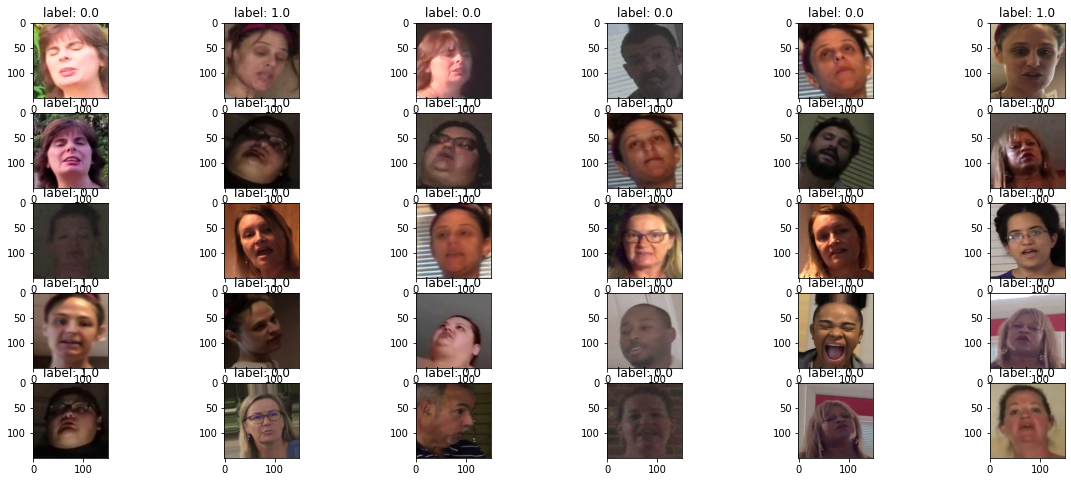

In [0]:
nrow, ncol = 5, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    image = np.rollaxis(image, 0, 3)
    image = image*std + mean
    image = np.clip(image, 0., 1.)
    ax.imshow(image)
    ax.set_title(f'label: {label}')

# 학습 함수 선언

## 모델 튜닝

In [0]:
class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.75)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

In [0]:
def criterion1(pred1, targets):
  l1 = F.binary_cross_entropy(F.sigmoid(pred1), targets)
  return l1

def train_model(epoch, optimizer, scheduler=None, history=None):
    model.train()
    total_loss = 0
    
    t = tqdm(train_loader)
    for i, (img_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion1(out, y_batch)

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        if history is not None:
          history.loc[epoch + i / len(X), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + i / len(X), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']

        loss.backward()
        optimizer.step()
        if scheduler is not None:
          scheduler.step()

def evaluate_model(epoch, scheduler=None, history=None):
    model.eval()
    loss = 0
    pred = []
    real = []
    with torch.no_grad():
        for img_batch, y_batch in val_loader:
            img_batch = img_batch.cuda().float()
            y_batch = y_batch.cuda().float()

            o1 = model(img_batch)
            l1 = criterion1(o1, y_batch)
            loss += l1
            
            for j in o1:
              pred.append(F.sigmoid(j))
            for i in y_batch:
              real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred2 = pred
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    real = [r.item() for r in real]
    pred2 = np.array(pred2).clip(0.1, 0.9)
    kaggle = sklearn.metrics.log_loss(real, pred2)

    loss /= len(val_loader)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    if scheduler is not None:
      scheduler.step(loss)

    print(f'Dev loss: %.4f, Acc: %.6f, Kaggle: %.6f'%(loss,acc,kaggle))
    
    return loss

# 학습

## xception net

In [0]:
!pip install pytorchcv --quiet
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=True)
# model = get_model("resnet18", pretrained=True)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
# model[0].final_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))

model = FCN(model, 2048)

     |████████████████████████████████| 399kB 8.5MB/s 


In [0]:
import gc

history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), f'model.pth')

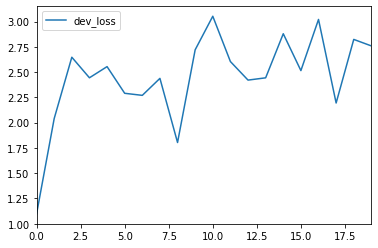

In [0]:
history2.plot()

In [0]:
xception_result = min(history2["dev_loss"])

## resnet

In [0]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)

In [0]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [0]:
checkpoint = torch.load("/content/gdrive/My Drive/Kaggle/DFDC/input/deepfakes-inference-demo/resnext.pth", map_location=gpu)

model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint)
_ = model.eval()

del checkpoint

In [0]:
history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), f'model.pth')

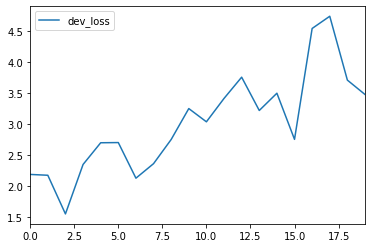

In [0]:
history2.plot()

In [0]:
resnext_result = min(history2["dev_loss"])

In [0]:
print(xception_result)
print(resnext_result)

1.096846103668213
1.5529732704162598


## tamper net

https://www.kaggle.com/c/deepfake-detection-challenge/discussion/121441

6 convolution layers

1 dense layers

In [0]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [0]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(128 * 46208, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [0]:
# CNN 모델 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [0]:
best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [0]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class TamperNet(nn.Module):
    def __init__(self):
        super(TamperNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        self.conv5 = nn.Conv2d(256, 512, 5)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv4(x)
        x = self.pool(F.relu(self.conv5(x)))

        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = TamperNet()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [0]:
for epoch in range(2):  # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 입력을 받은 후
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

In [0]:
import gc

history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), f'model.pth')



  0%|          | 0/24 [00:00<?, ?it/s]

RuntimeError: ignored

## efficient net

https://github.com/lukemelas/EfficientNet-PyTorch

In [0]:
pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=7e0a3b419d937f267f608e1911047387bd1e42de18302162ba8d1d1b3d460e75
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [0]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7') 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [0]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')

In [0]:
model = FCN(model, 2048)

In [0]:
import gc

history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), f'model.pth')


  0%|          | 0/24 [00:00<?, ?it/s]

RuntimeError: ignored